# Prerequisites

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# Load Excel File

In [4]:
import pandas as pd
master_df = pd.read_excel('1_master_synth.xlsx')
master_df.head()

,Type,Identity,Text,A2-Unambiguous,A4-Tolerances,A5-Sources specified,E1
0,ast_adc,HLRS_1747,Massive Data Broadcast shall immediately send ...,1,na,1,1
1,ast_adc,HLRS_6673,Massive Data Broadcast shall place a copied Re...,1,na,1,1
2,ast_adc,HLRS_2470,Massive Data Broadcast shall place a copied Ma...,1,na,1,1
3,ast_adc,HLRS_2467,Massive Data Broadcast shall send the current ...,1,na,na,1
4,ast_adc,HLRS_2468,Massive Data Broadcast shall send the current ...,1,na,na,1


In [5]:
model_df = master_df[['E1','Text']].copy()
model_df.head()

,E1,Text
0,1,Massive Data Broadcast shall immediately send ...
1,1,Massive Data Broadcast shall place a copied Re...
2,1,Massive Data Broadcast shall place a copied Ma...
3,1,Massive Data Broadcast shall send the current ...
4,1,Massive Data Broadcast shall send the current ...


In [6]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E1      3880 non-null   int64 
 1   Text    3880 non-null   object
dtypes: int64(1), object(1)
memory usage: 60.8+ KB


In [7]:
model_df_label1 = model_df.query('E1 == 1')
len(model_df_label1)

2408

In [8]:
model_df_label0 = model_df.query('E1 == 0')
len(model_df_label0)

1472

In [9]:
model_df = pd.concat([model_df_label1[:1500],model_df_label0])

# Data process and tokenizer

In [10]:
from sklearn.model_selection  import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.1, shuffle=True)

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [11]:
len(train_df)

2674

In [12]:
tokenizer = torch.hub.load(
    "huggingface/pytorch-transformers",
    "tokenizer",
    "roberta-large",
)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main


In [13]:
tokenizer

RobertaTokenizerFast(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

# Dataset iterator

In [14]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [15]:
next(train_iter)

(1,
 'Maintenance Message for a suppressed Fault shall be unsuppressed and reported in Normal Mode if the superceding Fault is cleared')

In [16]:
from torch.utils.data import DataLoader

# function passed to the DataLoader to process a batch of data as indicated
max_tokens = 50

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser

    encoded_x = tokenizer(x, padding=True, truncation=True)
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)  
    
    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return encoded_x, torch.tensor(y, dtype=torch.long).to(device)

In [17]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
first = next(train_iter)
second = next(train_iter)

print(first)
print(second)

collate_batch([first, second])

(1, 'Maintenance Message for a suppressed Fault shall be unsuppressed and reported in Normal Mode if the superceding Fault is cleared')
(0, 'Before the initial account setup, if there are some unsuccessful login attempts, the default account shall remain unlocked.')


({'input_ids': [[0, 31359, 42192, 32236, 13, 10, 31683, 42398, 5658, 28, 542, 16714, 10887, 8, 431, 11, 26411, 22158, 114, 5, 2422, 7618, 154, 42398, 16, 6049, 2], [0, 17206, 5, 2557, 1316, 11808, 6, 114, 89, 32, 103, 15943, 27754, 3881, 6, 5, 6814, 1316, 5658, 1091, 22804, 4, 2, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]},
 tensor([1, 0], device='cuda:0'))

# Define the model

In [18]:
model = torch.hub.load(
    "huggingface/pytorch-transformers",
    "modelForSequenceClassification",
    "roberta-large"
)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [20]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

2

In [21]:
for i, parameter in enumerate(model.parameters()):
    parameter.requires_grad = False

In [22]:
model.classifier.out_proj = nn.Linear(in_features=1024, out_features=num_class)

In [23]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

# Train and eval functions

In [24]:
from datetime import datetime, date
import time

def train(model, dataloader, epoch):
    
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0


    for idx, (data, label) in enumerate(dataloader):         
        optimizer.zero_grad()
        
        outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
        predicted_label = outputs.logits
        loss = criterion(predicted_label, label)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f} | {}".format(
                    epoch, idx, len(dataloader), total_acc / total_count, datetime.now().isoformat()
                )
            )
            start_time = time.time()
        
     
        
    return total_acc / total_count, total_loss / total_count
        

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):      
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs.logits
            loss = criterion(predicted_label, label)
            
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

# Split the dataset and run the model

In [25]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 64  # batch size for training

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [26]:
today = date.today().isoformat()
checkpoint_path = "./models/roberta_large"
model_name = "roberta_large"

# Hyperparameters
EPOCHS = 20  # epoch
LR = 0.1 # learning rate
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    
def train_with_hist(model, checkpoint_path):
    model = model.to(device)
    
    total_accu = None

    loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = [], [], [], []
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train(model, train_dataloader, epoch)
        accu_val, loss_val = evaluate(model, valid_dataloader)
        if total_accu is not None and total_accu > accu_val:
            scheduler.step()
            print("Learning rate took a step by the scheduler {:8.3f} > {:8.3f}".format(total_accu, accu_val))
        else:
            total_accu = accu_val
        print("-" * 59)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s | "
            "valid accuracy {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, accu_val
            )
        )
        print("-" * 59)

        loss_hist_train.append(loss_train)
        loss_hist_valid.append(loss_val)
        accuracy_hist_train.append(accu_train)
        accuracy_hist_valid.append(accu_val)
        
    torch.save(model, f'{checkpoint_path}/{today}_{model_name}.pt')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [27]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [28]:
hist = train_with_hist(model, checkpoint_path)

| epoch   1 |     5/   34 batches | accuracy    0.521 | 2024-04-08T17:48:34.492741
| epoch   1 |    10/   34 batches | accuracy    0.516 | 2024-04-08T17:48:35.751923
| epoch   1 |    15/   34 batches | accuracy    0.521 | 2024-04-08T17:48:36.723068
| epoch   1 |    20/   34 batches | accuracy    0.516 | 2024-04-08T17:48:38.745550
| epoch   1 |    25/   34 batches | accuracy    0.538 | 2024-04-08T17:48:39.866902
| epoch   1 |    30/   34 batches | accuracy    0.524 | 2024-04-08T17:48:40.759824
-----------------------------------------------------------
| end of epoch   1 | time: 10.57s | valid accuracy    0.488 
-----------------------------------------------------------
| epoch   2 |     5/   34 batches | accuracy    0.547 | 2024-04-08T17:48:44.142518
| epoch   2 |    10/   34 batches | accuracy    0.540 | 2024-04-08T17:48:45.287175
| epoch   2 |    15/   34 batches | accuracy    0.542 | 2024-04-08T17:48:46.988436
| epoch   2 |    20/   34 batches | accuracy    0.545 | 2024-04-08T17:48

In [29]:
import numpy as np
import matplotlib.pyplot as plt
def plot_learning_curves(hist):
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

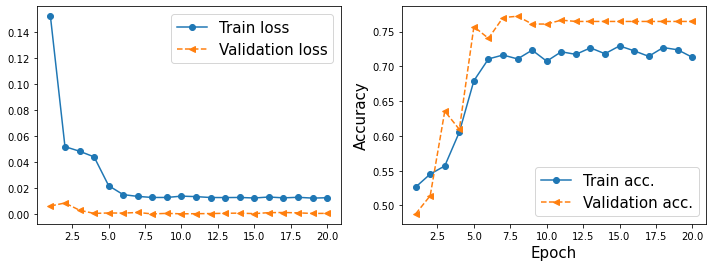

In [30]:
plot_learning_curves(hist)

### Evaluate the model with test dataset

Checking the results of the test dataset…



In [31]:
print("Checking the results of test dataset.")
accu_test, _ = evaluate(model, test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.772


In [32]:
# create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs.logits
                  
            y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76       152
         1.0       0.74      0.82      0.78       146

    accuracy                           0.77       298
   macro avg       0.77      0.77      0.77       298
weighted avg       0.78      0.77      0.77       298



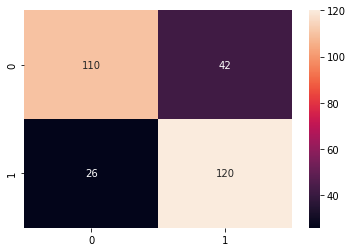

In [33]:
plot_confusion_matrix(model, test_dataloader)

In [34]:
def predict(text):
    with torch.no_grad():
        encoded_text = tokenizer(text)
        encoded_text.input_ids = torch.tensor(encoded_text.input_ids).to(device).unsqueeze(0)
        encoded_text.attention_mask = torch.tensor(encoded_text.attention_mask).to(device).unsqueeze(0)

        outputs = model(input_ids=encoded_text.input_ids, attention_mask=encoded_text.attention_mask)
        predicted_label = outputs.logits
        return predicted_label.argmax(1).item()

In [35]:
ex_text_str = 'The ePump Software shall define Fault ID 1 as follows:'

print("This is a %s" % predict(ex_text_str))

This is a 1


In [36]:
pred_text = "The IO Service shall select the XLR-PW DEV_INFO_DATA file if HPP_XLR_WIRING is grounded (logical 1) and bits AC_TYPE_BIT1 - AC_TYPE_BIT6 do not indicate a CFM engine configuration. NOTE: HPP_XLR_WIRING and bits AC_TYPE_BIT[1-6] are discrete inputs which are received on constant pins between hardware configurations. See 282100-ICD-x for more details."
predict(pred_text)

1

In [37]:
pred_text = "I shall like waffles"
predict(pred_text)

0

In [38]:
pred_text = "Bumblebe is red"
predict(pred_text)

0

In [39]:
pred_text = "Bumblebee is red"
predict(pred_text)

0

# Hyperparameter tunning with Ray Tune

In [42]:
import time
from datetime import datetime, date

import ray
import ray.train.torch

from ray import train, tune
from ray.train import RunConfig, ScalingConfig, Checkpoint
from ray.train.torch import TorchTrainer

from ray.tune.schedulers import ASHAScheduler

In [43]:
ray.train.torch.get_device()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-04-08 17:52:48,566	INFO worker.py:1724 -- Started a local Ray instance.


device(type='cuda', index=0)

In [44]:
from torch.utils.data import DataLoader

# function passed to the DataLoader to process a batch of data as indicated
max_tokens = 50

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    encoded_x = tokenizer(x, padding=True, truncation=True)
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask)
    
    return encoded_x, torch.tensor(y, dtype=torch.long)

In [45]:
def train_func(model, optimizer, train_loader, max_norm):  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0

    for idx, (encoded_x, label) in enumerate(train_loader):           
        label = label.to(device)
        
        
        encoded_x.input_ids = encoded_x.input_ids.to(device)
        encoded_x.attention_mask = encoded_x.attention_mask.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=encoded_x.input_ids, attention_mask=encoded_x.attention_mask)
        predicted_label = outputs.logits
        loss = criterion(predicted_label, label)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
         
    return total_acc / total_count, total_loss / total_count
        

def eval_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (encoded_x, label) in enumerate(data_loader):
            label = label.to(device)
            
            encoded_x.input_ids = encoded_x.input_ids.to(device)
            encoded_x.attention_mask = encoded_x.attention_mask.to(device)
            
            outputs = model(input_ids=encoded_x.input_ids, attention_mask=encoded_x.attention_mask)
            predicted_label = outputs.logits
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

In [47]:
def create_model():
    model = torch.hub.load(
        "huggingface/pytorch-transformers",
        "modelForSequenceClassification",
        "roberta-large"
    )
    
    for i, parameter in enumerate(model.parameters()):
        parameter.requires_grad = False
    
    model.classifier.out_proj = nn.Linear(in_features=1024, out_features=2)
    
    return model

In [48]:
import os
import tempfile

today = date.today().isoformat()
model_name = "roberta_large"
checkpoint_path = f"./models/{model_name}"
num_class = 2

def train_search(config):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    # print(device)
    # print(config)
    # config_params = config["params"]
    config_params = config
    # print(config_params)
    
    
    
    
    model = create_model()
    model = model.to(device)
    
    

    train_dataloader = DataLoader(
        split_train_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    valid_dataloader = DataLoader(
        split_valid_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=config_params["lr"])
    optimizer = torch.optim.SGD(model.parameters(), lr=config_params["lr"], momentum=config_params["momentum"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config_params["step_size"], gamma=config_params["lr_gamma"])
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(1, config_params["epochs"] + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train_func(model, optimizer, train_dataloader, config_params["max_norm"])
        accu_val, loss_val = eval_func(model, valid_dataloader)
        
        # Always let the scheduler take a step because it will be optimized by Hyperopt
        scheduler.step()
            
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if epoch % 5 == 0:
                # This saves the model to the trial directory
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Ray Tune
            train.report({
                "loss_train": loss_train,
                "loss_val": loss_val,
                "accuracy_train": accu_train,
                "accuracy_val": accu_val,
            }, checkpoint=checkpoint)

In [49]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [61]:
import numpy as np
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

exp_name = model_name

space = {
    "lr": hp.loguniform("lr", -3, 1),
    "momentum": hp.uniform("momentum", 0.01, 0.9),
    "epochs": hp.choice("epochs", [30]),
    "batch_size": hp.choice("batch_size", [16]),
    "step_size": hp.randint("step_size", 1, 10),
    "lr_gamma": hp.uniform("lr_gamma", 0.1, 0.9),
    "max_norm": hp.uniform("max_norm", 0.05, 0.3),
}

hyperopt_search = HyperOptSearch(space, metric="accuracy_val", mode="max")

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

tuner = tune.Tuner(
    tune.with_resources(train_search, resources={"cpu":8, "gpu":0.5}),
    tune_config=tune.TuneConfig(
        num_samples=30,
        scheduler=ASHAScheduler(metric="accuracy_val", mode="max"), # Early stopping
        search_alg=hyperopt_search, # Hyperopt library for Hyper-parameter Optimization
    ),
    run_config=train.RunConfig(
        name=exp_name,
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="accuracy_val",
            num_to_keep=2,
            # checkpoint_at_end=True
        ),
    ),
)
results = tuner.fit()

(train_search pid=142861) Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
(train_search pid=142861) Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
(train_search pid=142861) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_search pid=142919) Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_search pid=142919) Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large a

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

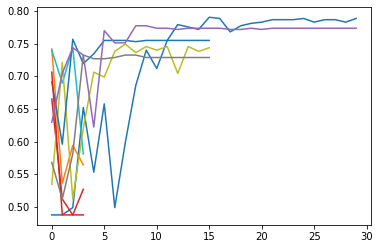

In [62]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d["accuracy_val"].plot() for d in dfs.values()]

In [63]:
best_result = results.get_best_result("accuracy_val", "max")
best_result.config

{'batch_size': 16,
 'epochs': 30,
 'lr': 1.9087440863780958,
 'lr_gamma': 0.7578901721561507,
 'max_norm': 0.2932115752163934,
 'momentum': 0.18754925546931656,
 'step_size': 1}

In [64]:
best_result.metrics_dataframe

,loss_train,loss_val,accuracy_train,accuracy_val,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,...,time_since_restore,iterations_since_restore,config/batch_size,config/epochs,config/lr,config/lr_gamma,config/max_norm,config/momentum,config/step_size,should_checkpoint
0,0.185235,0.008922,0.519402,0.487850,1712677656,None,False,1,e5943de6,2024-04-09_08-47-36,...,25.033157,1,16,30,1.908744,0.75789,0.293212,0.187549,1,NaN
1,0.109118,0.004044,0.536699,0.487850,1712677681,None,False,2,e5943de6,2024-04-09_08-48-01,...,50.164810,2,16,30,1.908744,0.75789,0.293212,0.187549,1,NaN
2,0.084355,0.002797,0.529219,0.499065,1712677706,None,False,3,e5943de6,2024-04-09_08-48-26,...,75.183125,3,16,30,1.908744,0.75789,0.293212,0.187549,1,NaN
3,0.069008,0.000536,0.583450,0.652336,1712677731,None,False,4,e5943de6,2024-04-09_08-48-51,...,100.030959,4,16,30,1.908744,0.75789,0.293212,0.187549,1,NaN
4,0.057711,0.001271,0.606358,0.553271,1712677754,checkpoint_000000,False,5,e5943de6,2024-04-09_08-49-15,...,124.043797,5,16,30,1.908744,0.75789,0.293212,0.187549,1,True
5,0.052255,0.000640,0.597943,0.657944,1712677777,None,False,6,e5943de6,2024-04-09_08-49-37,...,145.586050,6,16,30,1.908744,0.75789,0.293212,0.187549,1,NaN
6,0.045472,0.000774,0.632071,0.499065,1712677802,None,False,7,e5943de6,2024-04-09_08-50-02,...,170.857433,7,16,30,1.908744,0.75789,0.293212,0.187549,1,NaN
7,0.041826,0.001153,0.664797,0.598131,1712677827,None,False,8,e5943de6,2024-04-09_08-50-27,...,195.990263,8,16,30,1.908744,0.75789,0.293212,0.187549,1,NaN
8,0.039868,0.000860,0.661057,0.685981,1712677860,None,False,9,e5943de6,2024-04-09_08-51-00,...,228.604485,9,16,30,1.908744,0.75789,0.293212,0.187549,1,NaN
9,0.038736,0.001210,0.686770,0.740187,1712677892,checkpoint_000001,False,10,e5943de6,2024-04-09_08-51-34,...,262.482764,10,16,30,1.908744,0.75789,0.293212,0.187549,1,True


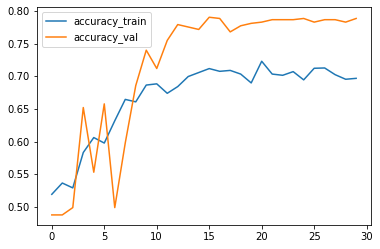

In [65]:
import matplotlib.pyplot as plt

df = best_result.metrics_dataframe

plt.plot(df['accuracy_train'], label='accuracy_train')
plt.plot(df['accuracy_val'], label='accuracy_val')

plt.legend(title='')

plt.show()

In [66]:
best_checkpoints = best_result.best_checkpoints
best_checkpoints

[(Checkpoint(filesystem=local, path=/home/it/ray_results/roberta_large/train_search_e5943de6_1_batch_size=16,epochs=30,lr=1.9087,lr_gamma=0.7579,max_norm=0.2932,momentum=0.1875,step_size=1_2024-04-09_08-47-09/checkpoint_000004),
  {'loss_train': 0.036129978367411796,
   'loss_val': 0.0008589977972975401,
   'accuracy_train': 0.6947171575502571,
   'accuracy_val': 0.788785046728972,
   'timestamp': 1712678244,
   'checkpoint_dir_name': 'checkpoint_000004',
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 25,
   'trial_id': 'e5943de6',
   'date': '2024-04-09_08-57-25',
   'time_this_iter_s': 24.144330739974976,
   'time_total_s': 613.9522049427032,
   'pid': 142861,
   'hostname': 'coeus',
   'node_ip': '10.1.1.204',
   'config': {'batch_size': 16,
    'epochs': 30,
    'lr': 1.9087440863780958,
    'lr_gamma': 0.7578901721561507,
    'max_norm': 0.2932115752163934,
    'momentum': 0.18754925546931656,
    'step_size': 1},
   'time_since_restore': 613.952204942703

In [67]:
best_checkpoint = best_result.get_best_checkpoint("accuracy_val", mode="max")

In [68]:
next(x for x in best_checkpoints if x[0].path == best_checkpoint.path)

(Checkpoint(filesystem=local, path=/home/it/ray_results/roberta_large/train_search_e5943de6_1_batch_size=16,epochs=30,lr=1.9087,lr_gamma=0.7579,max_norm=0.2932,momentum=0.1875,step_size=1_2024-04-09_08-47-09/checkpoint_000004),
 {'loss_train': 0.036129978367411796,
  'loss_val': 0.0008589977972975401,
  'accuracy_train': 0.6947171575502571,
  'accuracy_val': 0.788785046728972,
  'timestamp': 1712678244,
  'checkpoint_dir_name': 'checkpoint_000004',
  'should_checkpoint': True,
  'done': False,
  'training_iteration': 25,
  'trial_id': 'e5943de6',
  'date': '2024-04-09_08-57-25',
  'time_this_iter_s': 24.144330739974976,
  'time_total_s': 613.9522049427032,
  'pid': 142861,
  'hostname': 'coeus',
  'node_ip': '10.1.1.204',
  'config': {'batch_size': 16,
   'epochs': 30,
   'lr': 1.9087440863780958,
   'lr_gamma': 0.7578901721561507,
   'max_norm': 0.2932115752163934,
   'momentum': 0.18754925546931656,
   'step_size': 1},
  'time_since_restore': 613.9522049427032,
  'iterations_since_re

In [69]:
state_dict = torch.load(os.path.join(best_checkpoint.path, "model.pth"))

model = create_model()

model.load_state_dict(state_dict)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [70]:
uq_path = today + "_" + "_".join(best_result.path.split("=")[0].split("/")[-2:])
save_path = os.path.join(f'./models/{model_name}', uq_path + "_model.pt")
torch.save(model, save_path)